In [1]:
import numpy as np
from scipy.linalg import lu
from numpy.linalg import cholesky as llt
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
    })

## Least norm force sequence problem
Taken from VMLS book, page 343

In [2]:
def forward_substitution(L, b):
    n = L.shape[0]
    x = np.zeros(n)
    for i in range(n):
        x[i] = (b[i] - L[i,:i] @ x[:i])/L[i, i]
    return x

def backward_substitution(U, b):
    n = U.shape[0]
    x = np.zeros(n)
    for i in reversed(range(n)):
        x[i] = (b[i] - U[i,i+1:] @ x[i+1:])/U[i, i]
    return x

def lstsq(A, b):
    M = A.T.dot(A)
    q = A.T.dot(v_des)
    L = llt(M)
    x = forward_substitution(L, q)
    x = backward_substitution(L.T, x)
    return x
    
def con_lstsq(A, b, C, d):
    p, n = C.shape
    KKT = np.block([[2*A.T @ A, C.T], 
                    [C, np.zeros((p, p))]])
    rhs = np.hstack([2*A.T @ b, d])
    P, L, U = lu(KKT)
    x = P.T @ rhs
    x = forward_substitution(L, x)
    x = backward_substitution(U, x)
    return x[:n]

In [3]:
# Problem data
T = 10
A = np.eye(T)
b = np.zeros(T)
C_pos = np.arange(9.5, 0.4, -1).T
C = np.vstack([np.ones((1, T)), 
               C_pos]) 
d = np.array([0, 1])

In [4]:
## Bang-bang solution
f_bb = np.zeros(T)
f_bb[0:2] = [1, -1]
f_bb

array([ 1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [5]:
## Least norm solution
f_cls = con_lstsq(A, b, C, d)
f_cls

array([ 0.05454545,  0.04242424,  0.03030303,  0.01818182,  0.00606061,
       -0.00606061, -0.01818182, -0.03030303, -0.04242424, -0.05454545])

In [6]:
## Initial position
x0 = np.array([0, 0])

# Continuous time double integrator dynamics
# x = (v, p)
A_dyn = np.array([[0, 0], 
                  [1, 0]])
B_dyn = np.array([[1], 
                  [0]])

def simulate(T, A, B, f):
    N = 10000  # Time steps
    from scipy.signal import cont2discrete

    
    # Discretize system
    sysd = cont2discrete((A, B, np.eye(2), np.zeros((2, 1))), T/N)
    A = sysd[0]
    B = sysd[1]
    
    n, m = B.shape
    t = np.linspace(0, T, N+1, endpoint=False)
    x = np.zeros((n, N + 1))
    
    for k in range(N):
        # Get discrete-time input
        f_k = np.array([f[int(np.floor(t[k]))]])
        x[:, k+1] = A @ x[:, k] + B @ f_k
        
    return x[1, :], t

T = 10
x_cls, t_cls = simulate(T, A_dyn, B_dyn, f_cls)
x_bb, t_bb = simulate(T, A_dyn, B_dyn, f_bb)


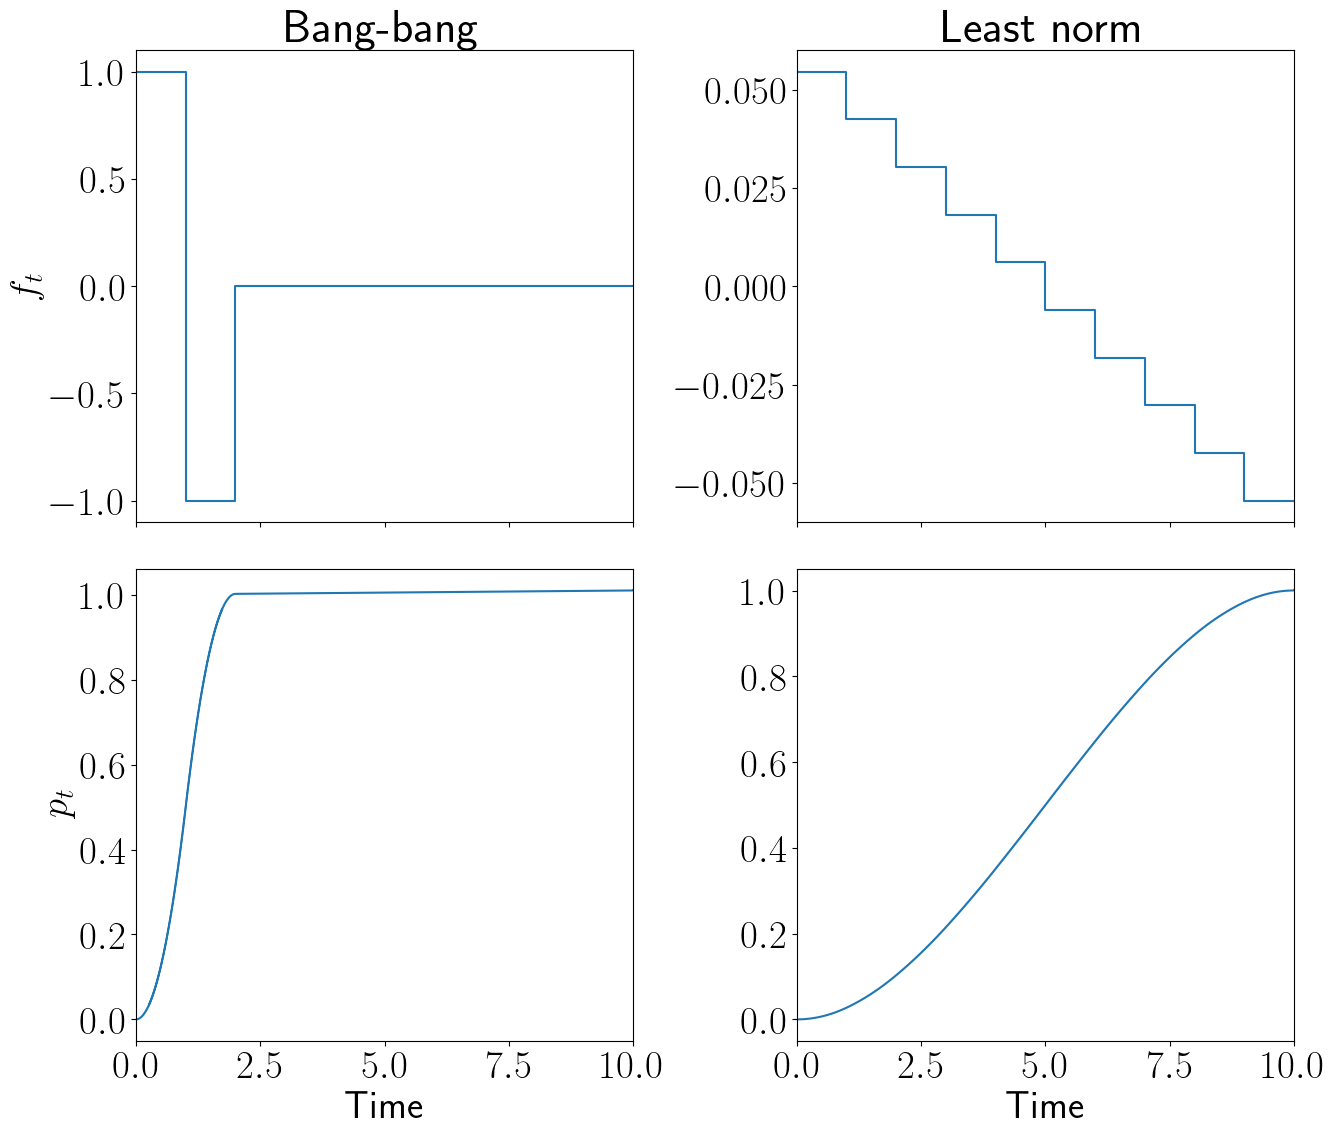

In [7]:
# Append duplicate last element to make step plots 
# look good
t = np.arange(11)
f_bb_plot = np.append(f_bb, f_bb[-1])
f_cls_plot = np.append(f_cls, f_cls[-1])

fig, ax = plt.subplots(2, 2, figsize=(14, 12), sharex=True)
ax[0, 0].step(t, f_bb_plot, where='post')
ax[0, 0].set_xlim(0, 10)
ax[0, 0].set_ylabel(r"$f_t$")
ax[0, 0].set_title("Bang-bang")
ax[1, 0].step(t_bb, x_bb, where='post')
ax[1, 0].set_xlim(0, 10)
ax[1, 0].set_xlabel("Time")
ax[1, 0].set_ylabel(r"$p_t$")
ax[0, 1].step(t, f_cls_plot, where='post')
ax[0, 1].set_xlim(0, 10)
ax[0, 1].set_title("Least norm")
ax[1, 1].step(t_cls, x_cls, where='post')
ax[1, 1].set_xlim(0, 10)
ax[1, 1].set_xlabel("Time")
plt.tight_layout()
plt.savefig("leastnorm.pdf")

In [8]:
# Input effort
print("||f_bb||^2 = ", np.sum(np.square(f_bb)))
print("||f_cls||^2 = ", np.sum(np.square(f_cls)))

||f_bb||^2 =  2.0
||f_cls||^2 =  0.01212121212121212
